---

# Setup

##### Set Root Dir as CWD

In [1]:
import os

# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


##### Imports

In [2]:
import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Local
from src.preprocesser import ReviewPreprocessor
from src.model import ReviewClassifier

# Load

In [3]:
path = "data/yelp/reviews/"

In [4]:
%%time
# Load dev set (10% of total data) as train
val = pd.read_pickle(path + "val.xz")

CPU times: total: 4.73 s
Wall time: 4.78 s


In [5]:
val

,text,stars
6211529,They are really professional and always sugges...,5
2795691,This is my new favourite sushi restaurant in E...,4
4040968,Fantastic visit here. Hapoy to find it on my a...,5
870450,I have eaten here on a few occasions. There is...,3
5479481,This place is a disgrace. Their customer servi...,1
...,...,...
5103142,I was born and raised in Chicago on thin crust...,5
423717,I love Mee Lu. I will be going back for waxing...,4
4806837,Fun English restaurant/bar in the heart of Phi...,3
6131355,So my wife and I ordered from crave tonight......,3


##### Save Target

In [7]:
# Save reviews stars from 0-4
y_val = tf.convert_to_tensor(val["stars"].values - 1)

# Preprocess

In [9]:
batch_size = 4000
n_processes = 4

maxlen = 200         # Number of words per review to consider
vocab_size = 20_000  # Size of vocabulary

prep_path = f"experiments/preprocessors/final.pickle"

##### Load from raw data

In [12]:
%%time
# Configure preprocessor based on comparison
prep = ReviewPreprocessor.load_from_pickle(prep_path)

# Preprocess text
X_val_norm = prep.normalize(val["text"], batch_size, n_processes)

# Convert to tensor of padded sequences
X_val = prep.to_tensor(X_val_norm)

CPU times: total: 1h 23min 24s
Wall time: 3h 10min 1s


##### View Before and After Preprocessing

In [12]:
print_idx = 8
print(val["text"].iloc[print_idx])
print("\n - - - - \n")
print(X_val_norm[print_idx], len(X_val_norm[print_idx]))
print("\n - - - - \n")
print(X_val[print_idx])

Ordered through grub hub, food came half an hour past the maximum delivery window. A simple breakfast order took 90 minutes to get to me, and the potatoes were half raw. Delivery timing may not have been the restaurant's fault, but the undercooked food was.

Delivery fee is actually $3.99, NOT $0 as posted on yelp

 - - - - 

['ordered', 'through', 'grub', 'hub', ',', 'food', 'came', 'TIME', 'TIME', 'TIME', 'past', 'the', 'maximum', 'delivery', 'window', '.', 'a', 'simple', 'breakfast', 'order', 'took', '90', 'e0', 'TIME', 'to', 'get', 'to', 'me', ',', 'and', 'the', 'potatoes', 'were', 'CARDINAL', 'raw', '.', 'delivery', 'timing', 'may', 'not', 'have', 'been', 'the', 'restaurant', "'", 's', 'fault', ',', 'but', 'the', 'undercooked', 'food', 'was', '.', 'delivery', 'fee', 'is', 'actually', '$', '3', 'e0', '.', '99', 'e0', ',', 'not', '$', '0', 'e0', 'as', 'posted', 'on', 'yelp'] 73

 - - - - 

tf.Tensor(
[ 104  290 3711 5009    4   38  115   23   23   23  783    2 7513  593
  900    1  

# Model

* Reference https://keras.io/examples/nlp/text_classification_with_transformer/

##### Load Model

In [10]:
# Model
model = keras.models.load_model("experiments/models/final_model")

In [14]:
model.predict(X_train[:5])

1/1 [==============================] - 2s 2s/step


array([[0.15694028, 0.19558105, 0.1585571 , 0.24361321, 0.24530843],
       [0.1702983 , 0.21328758, 0.07838115, 0.31940526, 0.21862768],
       [0.14197375, 0.205456  , 0.03435435, 0.40518376, 0.21303208],
       [0.15400489, 0.18007413, 0.12180891, 0.27932695, 0.26478514],
       [0.14453752, 0.20823543, 0.03128969, 0.40455407, 0.21138325]],
      dtype=float32)

In [16]:
model.summary()

Model: "review_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 t_emb (Embedding)           multiple                  640000    
                                                                 
 p_emb (Embedding)           multiple                  6400      
                                                                 
 attention (MultiHeadAttenti  multiple                 8416      
 on)                                                             
                                                                 
 sequential (Sequential)     (None, 200, 32)           1056      
                                                                 
 layer_normalization (LayerN  multiple                 64        
 ormalization)                                                   
                                                                 
 layer_normalization_1 (Laye  multiple           

# Evaluate

In [51]:
# Get probabilities per class
y_pred = model.predict(X_val)

21845/21845 [==============================] - 36s 2ms/step


In [52]:
# Get star predictions and negative/positive predictions
y_pred_multi = tf.argmax(y_pred, axis=1)

In [53]:
# Calculate continuous star rating based on probabilities
star_reg = tf.reduce_sum(y_pred * np.array([0, 1, 2, 3, 4]), axis=1)
star_reg

<tf.Tensor: shape=(699028,), dtype=float64, numpy=
array([3.91745288, 3.82218743, 0.09109641, ..., 3.96920484, 3.10105394,
       3.89718001])>

In [54]:
# Determine if sentiment is negative or postiive
y_pred_binary = star_reg > 2

In [55]:
print("multi-class accuracy: " + str((y_pred_multi == y_test).numpy().sum() / len(y_test)))
print("(compare to ~0.2)")

multi-class accuracy: 0.6949950502698032
(compare to ~0.2)


In [56]:
print("binary accuracy: " + str((y_pred_binary == (y_test >= 3)).numpy().sum() / len(y_test)))
print("(compare to ~0.5)")

binary accuracy: 0.9059236539881093
(compare to ~0.5)


In [57]:
avg_err = tf.reduce_sum(tf.math.abs(y_test - y_pred_multi)) / len(y_test)
avg_err = avg_err.numpy()
print(f"Mean Absolute Error: Average of {avg_err:.4f} stars off")

Average of 0.3809 stars off


##### Visualize Attention

In [58]:
# Get attention scores
_, attns = model(X_test[:100], return_att=True)

# Get attention for each sample
attns = tf.reduce_mean(attns, axis=2)[:, 0, :]
attns

<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[0.04983199, 0.        , 0.03516538, ..., 0.        , 0.        ,
        0.        ],
       [0.00950472, 0.20049529, 0.005     , ..., 0.        , 0.        ,
        0.        ],
       [0.07      , 0.27999842, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.025     , 0.08984116, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.005     , 0.03      , 0.07      , ..., 0.        , 0.        ,
        0.        ],
       [0.135     , 0.17285107, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [59]:
attns[0][:34]

<tf.Tensor: shape=(34,), dtype=float32, numpy=
array([4.98319902e-02, 0.00000000e+00, 3.51653807e-02, 5.75425662e-02,
       1.99999996e-02, 1.98365208e-02, 3.50033864e-02, 0.00000000e+00,
       1.99999996e-02, 0.00000000e+00, 0.00000000e+00, 9.99999978e-03,
       0.00000000e+00, 0.00000000e+00, 4.99999989e-03, 0.00000000e+00,
       0.00000000e+00, 6.46237913e-06, 0.00000000e+00, 9.99999978e-03,
       6.28405600e-04, 0.00000000e+00, 3.43715958e-02, 0.00000000e+00,
       3.89999241e-01, 0.00000000e+00, 2.74574328e-02, 0.00000000e+00,
       9.99999978e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00017525e-02, 1.50034457e-01], dtype=float32)>

<Original Text>
This place is NOT closed.  We went there on 18 August 2017.  Great, great corned beef and pastrami sandwich, the Bains special.  Also wonderful Italian sub and tuna sandwich.  Our picky son, who eats nothing, actually ate a third of his sister's sandwich.  One of the best lunches we've had in a long time.  Really nice staff and not a bad price.

<Preprocessed>
['place', 'close', 'go', '18', 'e0', 'date', '20', 'e2', 'great', 'great', 'corned', 'beef', 'pastrami', 'sandwich', 'norp', 'special', 'wonderful', 'norp', 'sub', 'tuna', 'sandwich', 'picky', 'son', 'eat', 'actually', 'eat', 'ordinal', 'sister', "'", 's', 'sandwich', 'cardinal', 'good', 'lunch', "'", 've', 'long', 'time', 'nice', 'staff', 'bad', 'price']


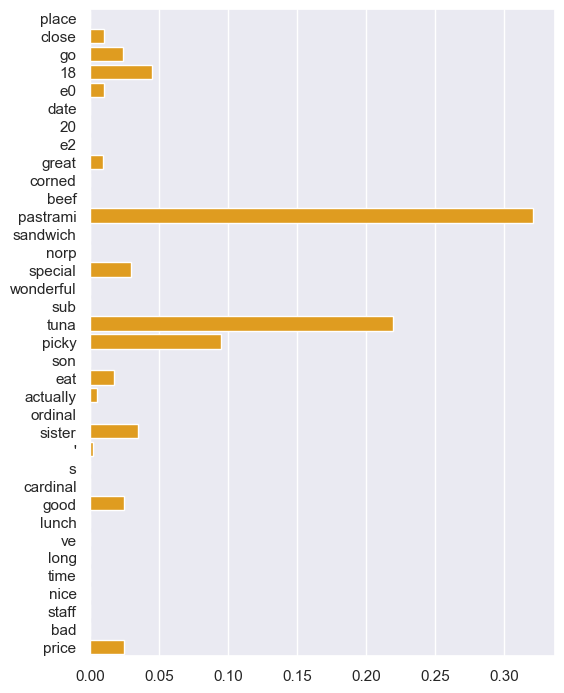

In [66]:
sample_idx = 6

# Get word sequences without oov words
in_seq = X_test_norm[sample_idx]
in_seq = [tok for tok in prep.tokenizer.sequences_to_texts(prep.tokenizer.texts_to_sequences(in_seq)) if tok]
seq_len = len(in_seq)

# Get attention values
attn_vals = attns[sample_idx][:seq_len].numpy()

print("<Original Text>")
print(test["text"].iloc[sample_idx])

print("\n<Preprocessed>")
print(in_seq)

plt.figure(figsize=(6, 0.2 * seq_len), dpi=100)
sns.barplot(y=in_seq, x=attn_vals, ci=None, color="orange")

plt.show()